In [0]:
# Import libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.nn import Linear, Conv2d
from torch import nn

In [0]:
# Hyperameters of the model
num_classes = 2 # Skin vs. Not skin
height = 100    # Input image height
width = 100     # Input image width

In [0]:
def compute_conv_dim(i,k,p,s):
    # out_dim = (input_dim - kernel_filter_dim + 2 * padding) / stride + 1
    return int((i - k + 2 * p) / s + 1)

Define the neural network that has some learnable parameters (or weights)

In [0]:
# Define the neural network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = Conv2d(3,16,3)
        self.conv2 = Conv2d(16,16,3)
        self.conv3 = Conv2d(16,16,3)
        self.conv4 = Conv2d(16,128,3)

        self.conv_out_height = compute_conv_dim(48,3,0,1)
        self.conv_out_width = compute_conv_dim(48,3,0,1)
    
        self.l1_in_features = 128 * self.conv_out_height * self.conv_out_width

        self.fc1 = Linear(in_features=self.l1_in_features, 
                          out_features=1)
        self.fc2 = Linear(in_features=1, 
                            out_features=num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=270848, out_features=1, bias=True)
  (fc2): Linear(in_features=1, out_features=2, bias=True)
)


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [0]:
# Test the forward pass with dummy data
# Random input
input = torch.randn(16, 3, 100, 100)
out = net(input)
print(out.size())
print(out)

torch.Size([16, 2])
tensor([[0.7109, 0.3160],
        [0.7127, 0.3159],
        [0.7129, 0.3159],
        [0.7112, 0.3159],
        [0.7115, 0.3159],
        [0.7110, 0.3159],
        [0.7107, 0.3160],
        [0.7116, 0.3159],
        [0.7117, 0.3159],
        [0.7105, 0.3160],
        [0.7106, 0.3160],
        [0.7118, 0.3159],
        [0.7115, 0.3159],
        [0.7097, 0.3160],
        [0.7105, 0.3160],
        [0.7115, 0.3159]], grad_fn=<SigmoidBackward>)


In [0]:
from sklearn.metrics import accuracy_score
# train dataset will have 800 000 images
batch_size = 100 # 1000?
num_epochs = 50

num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size  #800 000/100 = 8000
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slce]))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')

### Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds.data.numpy()))))

NameError: ignored

Iterate over a dataset of inputs

In [0]:
# Not using this
'''
# Load image net dataset
imagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=args.nThreads)
next(data_loader)
'''

"\n# Load image net dataset\nimagenet_data = torchvision.datasets.ImageNet('path/to/imagenet_root/')\ndata_loader = torch.utils.data.DataLoader(imagenet_data,\n                                          batch_size=4,\n                                          shuffle=True,\n                                          num_workers=args.nThreads)\nnext(data_loader)\n"

 Process input through the network

 Compute the loss (how far is the output from being correct)

Propagate gradients back into the network’s parameters

Update the weights of the network, typically using a simple update rule: weight = weight - learning_rate * gradient

In [0]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Go to the your drive folder
% cd './drive/My Drive/'

# Specify the folder that contains the ISIC 2019 data
data_dir = '/content/drive/My Drive/dataset'
# Verify files are there
% ls

/content/drive/My Drive
'Colab Notebooks'/   dataset/


In [0]:
import os
from glob import glob
# Create column path to store each image path
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
imageid_path_dict

{'00000000': '/content/drive/My Drive/dataset/skin/00000000.jpg',
 '00000001': '/content/drive/My Drive/dataset/skin/00000001.jpg',
 '00000002': '/content/drive/My Drive/dataset/skin/00000002.jpg',
 '00000003': '/content/drive/My Drive/dataset/skin/00000003.jpg',
 '00000004': '/content/drive/My Drive/dataset/skin/00000004.jpg',
 '00000005': '/content/drive/My Drive/dataset/skin/00000005.jpg',
 '00000006': '/content/drive/My Drive/dataset/skin/00000006.jpg',
 '00000007': '/content/drive/My Drive/dataset/skin/00000007.jpg',
 '00000008': '/content/drive/My Drive/dataset/skin/00000008.jpg',
 '00000009': '/content/drive/My Drive/dataset/skin/00000009.jpg',
 '00000010': '/content/drive/My Drive/dataset/skin/00000010.jpg',
 '00000011': '/content/drive/My Drive/dataset/not_skin/00000011.jpg',
 '00000012': '/content/drive/My Drive/dataset/not_skin/00000012.jpg',
 '00000013': '/content/drive/My Drive/dataset/skin/00000013.jpg',
 '00000014': '/content/drive/My Drive/dataset/skin/00000014.jpg',
 '

In [0]:
import pandas as pd
import numpy as np
df = pd.DataFrame.from_dict(imageid_path_dict, orient='index', columns=['image_paths'])
df = df.reset_index(drop=True)
df['label'] = 0
df['label'] = df['image_paths'].str.extract(r'dataset\W(\w+)\W')
# Create column lesion_code to store lesion codes
df['lesion_code'] = pd.Categorical(df['label']).codes
df.head()

,image_paths,label,lesion_code
0,/content/drive/My Drive/dataset/skin/00000002.jpg,skin,1
1,/content/drive/My Drive/dataset/skin/00000003.jpg,skin,1
2,/content/drive/My Drive/dataset/skin/00000004.jpg,skin,1
3,/content/drive/My Drive/dataset/skin/00000005.jpg,skin,1
4,/content/drive/My Drive/dataset/skin/00000006.jpg,skin,1


In [0]:
#y = df.pop('label').to_frame()
#X = df

In [0]:
from sklearn.model_selection import train_test_split
train_val, test = train_test_split(df, test_size=0.1)

In [0]:
train, val = train_test_split(train_val, test_size=0.1) #stratify=train_val['label']

In [0]:
# Get the number of images per lesion
train['label'].value_counts()

skin        137
not_skin     21
Name: label, dtype: int64

In [0]:
# Calculate the augmentation rate
b_df = pd.Series.to_frame(train['label'].value_counts())
b_df['rate'] = round(b_df['label'].max()/b_df['label'])
b_df['rate'] = b_df['rate'].replace(1, 0)  # 0 augmentation for the max value
b_df = b_df.sort_index()
b_df = b_df.astype(int, errors='ignore')
b_df['w_augmentation'] = b_df['label'] * b_df['rate']
b_df

,label,rate,w_augmentation
not_skin,21,7,147
skin,137,0,0


In [0]:
# Oversample (copy images from) the minority classes to balance the number of 8 classes
data_aug_rate = list(b_df.rate)
for i in range(1): # number of classes minus 1
    if data_aug_rate[i]:
        train = train.append([train.loc[train['lesion_code'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)

        # Balanced classes
train['label'].value_counts()

not_skin    147
skin        137
Name: label, dtype: int64

In [0]:
train.head()

,image_paths,label,lesion_code
0,/content/drive/My Drive/dataset/skin/00000187.jpg,skin,1
1,/content/drive/My Drive/dataset/skin/00000091.jpg,skin,1
2,/content/drive/My Drive/dataset/skin/00000154.jpg,skin,1
3,/content/drive/My Drive/dataset/not_skin/00000...,not_skin,0
4,/content/drive/My Drive/dataset/skin/00000093.jpg,skin,1


In [0]:
val.head()

,image_paths,label,lesion_code
138,/content/drive/My Drive/dataset/skin/00000076.jpg,skin,1
98,/content/drive/My Drive/dataset/skin/00000182.jpg,skin,1
170,/content/drive/My Drive/dataset/skin/00000161.jpg,skin,1
132,/content/drive/My Drive/dataset/skin/00000045.jpg,skin,1
48,/content/drive/My Drive/dataset/skin/00000078.jpg,skin,1


In [0]:
import torch
from torch.utils.data import DataLoader,Dataset
from PIL import Image

# Define a pytorch dataloader for this dataset
class ISIC2019(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['image_paths'][index])
        y = torch.tensor(int(self.df['lesion_code'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

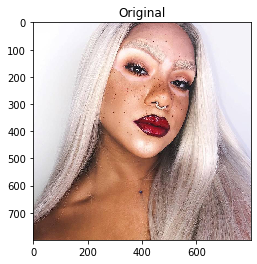

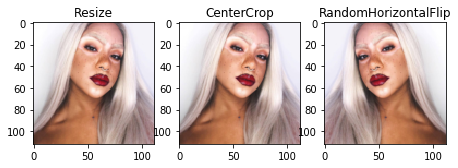

In [0]:
import matplotlib.pyplot as plt
from torchvision import models,transforms
# Code to visualize and decide data parameters
lesions = ISIC2019(train)

image, label = next(iter(lesions))

# Plot the original image
fig = plt.figure()
plt.imshow(image)
plt.title('Original')

# Transformations
resize = transforms.Resize(112)
crop = transforms.CenterCrop((112,112))
flip = transforms.RandomHorizontalFlip()

# Plot the image after the transformations
f = plt.figure(figsize=(10,10))
for i,tsfrm in enumerate([resize,crop,flip]):
  image = tsfrm(image)
  ax = f.add_subplot(1, 4, i + 1)
  ax.set_title(type(tsfrm).__name__)
  plt.imshow(image)

In [0]:
# ImageNet statistics
mean = [0.485, 0.456, 0.406] 
std = [0.229, 0.224, 0.225]

# Define the transformation of the train images.
train_transform_600 = transforms.Compose([transforms.Resize(600),
                                      transforms.CenterCrop((600,600)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])
# Define the transformation of the validation images.
val_transform_600 = transforms.Compose([transforms.Resize(600),
                                      transforms.CenterCrop((600,600)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])

In [0]:
# Define the training sets
training_set_600 = ISIC2019(train, transform=train_transform_600)

# Define the validation set
val_set_600 = ISIC2019(val, transform=val_transform_600)

In [0]:

# Model to be used for training
class PretrainedModel_600(nn.Module):
    def __init__(self,output_features):
        super().__init__()
        model = EfficientNet.from_pretrained('efficientnet-b7')
        num_ftrs = model._fc.in_features
        model._fc = nn.Linear(num_ftrs, output_features)
        self.model = model
            
    def forward(self, x):
        x = self.model(x)
        return x

In [0]:
# Data for Net 600
%%timeit
train_loader_600 = DataLoader(training_set_600, batch_size=10,shuffle=True, num_workers=2)
X,y = next(iter(train_loader_600))
X,y = X.numpy(),y.numpy() # assuming X and y are torch.Tensor
X,y = X.astype('float32'), y.astype('int64')

1 loop, best of 3: 1.06 s per loop


In [0]:
# Data for Net 600
%%timeit
val_loader_600 = DataLoader(val_set_600, batch_size=10,shuffle=True, num_workers=2)
X,y = next(iter(val_loader_600))
X,y = X.numpy(),y.numpy() # assuming X and y are torch.Tensor
X,y = X.astype('float32'), y.astype('int64')

KeyError: ignored

In [0]:
# Hyperparameter search for Net600

In [0]:
y_train = train.pop('label').to_frame()
X_train = train

y_val = val.pop('label').to_frame()
X_val = val

y_test = test.pop('label').to_frame()
X_test = test


In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)